# Image Segmentation

**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title ## Utilities { display-mode: "form" }
#@markdown Main imports, global variables, models and function definitions

# colab forms tutorial
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=ZCEBZPwUDGOg

import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt
import random

from io import BytesIO
from urllib.request import urlopen, Request

seed = 42
img_size = (256,256) #gt_image size, and network output size
down_factor = 4
preprocess_data = True # turn False if you have ready your data
data_augmentation = True
BATCH_SIZE = 1
num_classes = 3

downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
up_factor = down_factor

def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
  random.seed(seedValue)
set_seed(seed)
print("Tensorflow version: ", tf.__version__ )

#################
### Utilities ###
#################

### Functions to display

def create_mask(pred_mask, return_all = False):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  if return_all:
    return pred_mask
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(10,5))

  title = ['Imagen de entrada (red segmentacion)', 'Mascara predicha', 'Raw prediction']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #print(display_list[i]) # raw image values
    #print("---------")
    #plt.axis('off')
  plt.show()

def show_predictions(gt, display_raw_mask = False):
    pred_img = model.predict(gt[tf.newaxis, ...])
    images = [gt, create_mask(pred_img)]

    if display_raw_mask:
        images = images + [pred_img[0]]
    display(images)



### jaccard function (IoU)
# dentro de la funcion da error
jaccard = tf.keras.metrics.MeanIoU(num_classes=num_classes) 

def jaccard_index(y_true, y_pred):
    """Define Jaccard index.
       Args:
            y_true (tensor): ground truth masks. (w, h, 1)
            y_pred (tensor): predicted masks. (w,h, num_classses)
       Return:
            jac (tensor): Jaccard index value
    """
    # argmax
    # (w,h,3) [0-1] values -> (w,h) [1,2,...,(num_classes)] classes
    y_pred = tf.math.argmax(y_pred, axis=-1) 

    # type int
    y_pred_ = tf.cast(y_pred, dtype=tf.uint8)
    y_true = tf.cast(y_true, dtype=tf.uint8)

    # flatten
    #y_pred = tf.reshape(y_pred, [-1])
    #y_true = tf.reshape(y_true, [-1])
    
    jaccard.reset_states() # clean
    jaccard.update_state(y_true, y_pred_) # compute
    jac = tf.cast(jaccard.result(), dtype=tf.float64) # get result

    return jac



### Image preprocess functions

from skimage import filters
from PIL import Image

def classic_crappify(img):
    im = np.asarray(img, dtype=np.float32)
    im = filters.gaussian(im, sigma=3, multichannel=True) + 1e-6 + 2e-7 #(salt and peper)
    im = np.rint(im)
    im = np.asarray(im, dtype=np.uint8)
    return Image.fromarray(im)

def sub1(mask):
    # [3,2,1] -> [2,1,0]
    m = np.asarray(mask, dtype=np.uint8) - 1
    return Image.fromarray(m)

# input: PIL image object
# output: numpy array
def image_preprocess(image):
    # Convert (RGBA,...) images to RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply moddifications (crappify, resize, ...)
    gt_img = image.resize(img_size, Image.BILINEAR)

    gt_img = np.asanyarray(gt_img) / 255 # normalize

    return gt_img




####################
###### Models ######
####################

from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Lambda, GlobalAveragePooling2D, Multiply, Dense, Reshape
from tensorflow.keras.models import Model

import sys
sys.setrecursionlimit(10000)

def sub_pixel_conv2d(scale=2, **kwargs):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale), **kwargs)


def upsample(input_tensor, filters, use_mish=False):
    x = Conv2D(filters=filters * 4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale=2)(x)
    if use_mish:
        x = Mish()(x)
    else:
        x = Activation('relu')(x)
    return x


def ca(input_tensor, filters, reduce=16):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Reshape((1, 1, filters))(x)
    x = Dense(filters/reduce,  activation='relu', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    x = Multiply()([x, input_tensor])
    return x


def rcab(input_tensor, filters, scale=0.1):
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = ca(x, filters)
    if scale:
        x = Lambda(lambda t: t * scale)(x)
    x = Add()([x, input_tensor])

    return x


def rg(input_tensor, filters, n_rcab=20):
    x = input_tensor
    for _ in range(n_rcab):
        x = rcab(x, filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rir(input_tensor, filters, n_rg=10):
    x = input_tensor
    for _ in range(n_rg):
        x = rg(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rcan(filters=64, n_sub_block=2, out_channels=1, input_size=(None,None,3)):
    inputs = Input(shape=input_size)

    x = x_1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = rir(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x_1, x])

    #for _ in range(n_sub_block):
    #    x = upsample(x, filters, use_mish=use_mish)
    #x = Conv2D(filters=out_channels, kernel_size=3, strides=1, padding='same')(x)

    outputs = Conv2D(out_channels, (1, 1), padding='same') (x)

    return Model(inputs=inputs, outputs=outputs)

Tensorflow version:  2.5.0


In [3]:
#@title ## Load model weights { display-mode: "form" }

from tensorflow.keras.losses import SparseCategoricalCrossentropy

# learning rate
lr = 5e-4
# initial filters
num_filters = 32

loss_funct = SparseCategoricalCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam( learning_rate=lr )
input_size = img_size + (3,)

model = rcan(n_sub_block=int(np.log2(down_factor)),
                filters=num_filters,
                out_channels = num_classes,
                input_size=input_size)


model_path = '/content/drive/MyDrive/TFG/models/weights-rcan-RCAN-nf-32-SCCE-bs-1-Adam-oneCycle-256x256.h5'#@param {type:"string"}

model.load_weights(model_path)
model.compile(optimizer=optim, loss=loss_funct, metrics=[jaccard_index])

#@markdown ---
#@markdown **(beta)**
show_model_architecture = False #@param {type:"boolean"}
if show_model_architecture:
    tf.keras.utils.plot_model(model, show_shapes=True)

# import everything about the model from 1 file. 
# problem with rcan, due to custom metrics
#model_path = '/content/drive/MyDrive/TFG/models/my_model'
#model = tf.keras.models.load_model(model_path)

https://catpedia.net/wp-content/uploads/2018/01/Bengal-cat.jpg,https://www.mascotahogar.com/1920x1080/wallpaper-de-un-caballo-salvaje.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Volorful-parrot-animal-wallpaper-HD.jpg,https://www.pixelstalk.net/wp-content/uploads/images2/Screen-Download-Animal-Wallpapers.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-background.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpaper-HD-for-free.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-Birds-Wallpaper-HD-1920x1080.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-free-download.jpg,https://tailandfur.com/wp-content/uploads/2014/09/beautiful-and-cute-animals-wallpaper-51.jpg,https://4.bp.blogspot.com/-CO5-mntxeWo/Tvc3bTvFLTI/AAAAAAAAT18/H0Zu1zr_ITM/s1600/animals-widescreen-wallpapers-animals.jpg,https://3.bp.blogspot.com/-Gf-f7GSnp8U/Tvc3auZfg8I/AAAAAAAAT1s/zaWFB9tHT3c/s1600/Animals%2BWallpapers.jpg,https://1.bp.blogspot.com/_UmpGmlMW_Ek/TKJil9BMv_I/AAAAAAAAAAU/HgflMrUMvX8/w1200-h630-p-k-no-nu/bicicletas+specialized.jpg,https://astelus.com/wp-content/viajes/paisaje-marino-lago-jackson.jpg,http://dibujos.drawing-of.eu/wp-content/uploads/2017/03/kot.jpg,https://i2.wp.com/consciouscat.net/wp-content/uploads/2015/11/kitten-drawing.jpg,https://www.masscience.com/wp-content/uploads/2016/01/infinito.jpg,https://i.pinimg.com/originals/aa/96/94/aa9694a73702278c3b09aadfeecef7e4.jpg,https://i.ytimg.com/vi/H6Iq-pTxbAs/hqdefault.jpg

['/content/Bengal_28.jpg', '/content/Abyssinian_20.jpg', '/content/Abyssinian_141.jpg', '/content/Bengal_182.jpg', '/content/Abyssinian_134.jpg', '/content/Abyssinian_2.jpg', '/content/Abyssinian_142.jpg', '/content/Abyssinian_7.jpg', '/content/Abyssinian_31.jpg', '/content/Abyssinian_79.jpg', '/content/Abyssinian_180.jpg']
Image correctly downloaded.
Processing...



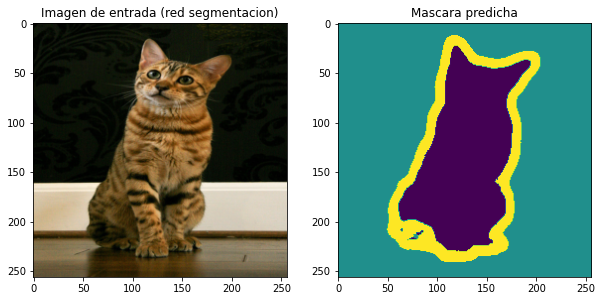

Image correctly downloaded.
Processing...



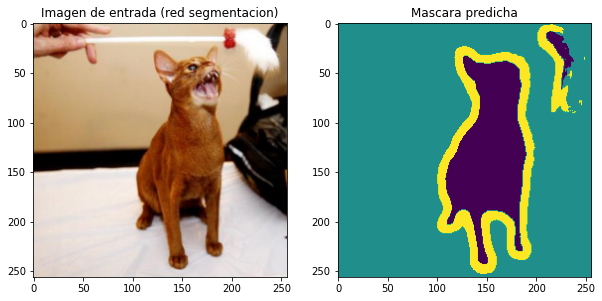

Image correctly downloaded.
Processing...



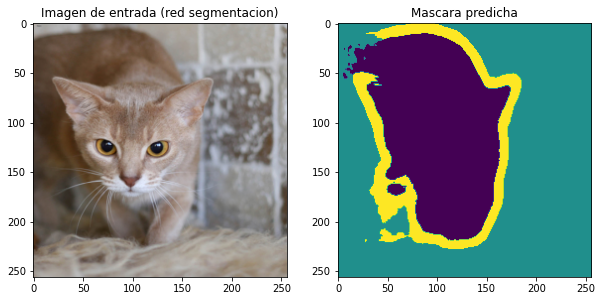

Image correctly downloaded.
Processing...



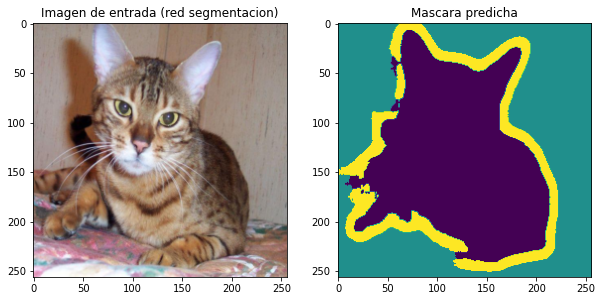

Image correctly downloaded.
Processing...



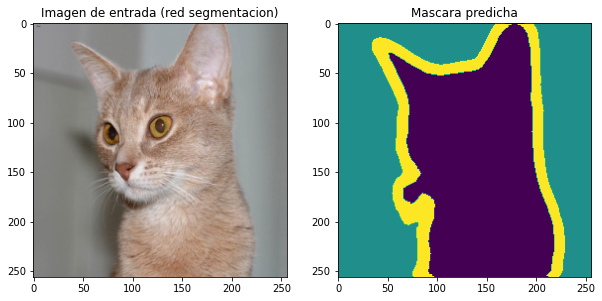

Image correctly downloaded.
Processing...



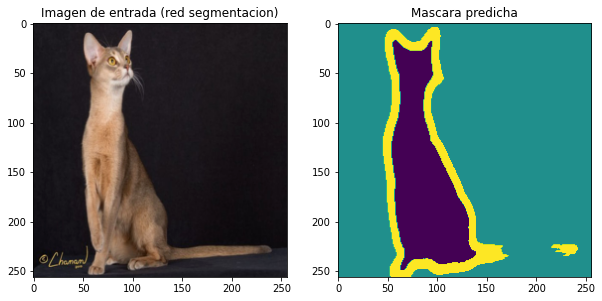

Image correctly downloaded.
Processing...



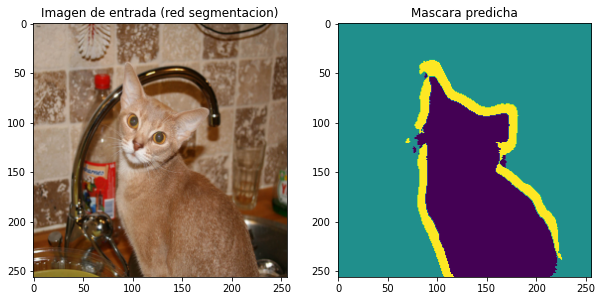

Image correctly downloaded.
Processing...



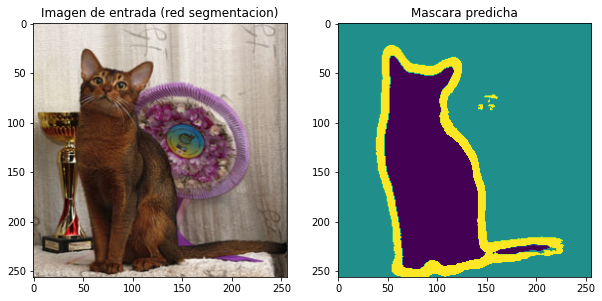

Image correctly downloaded.
Processing...



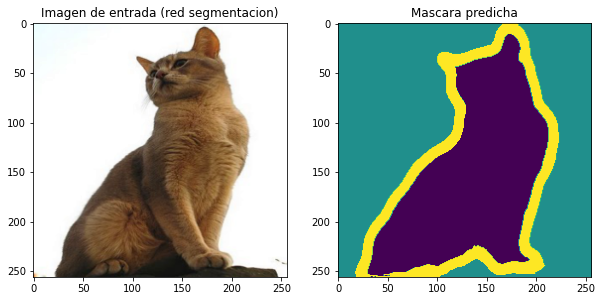

Image correctly downloaded.
Processing...



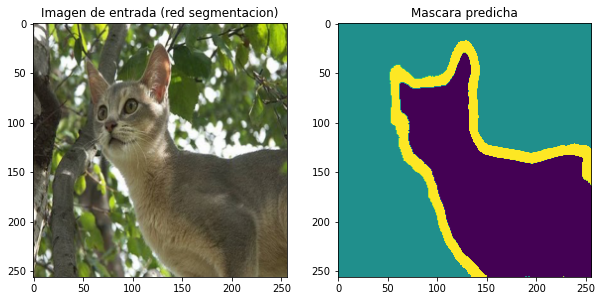

Image correctly downloaded.
Processing...



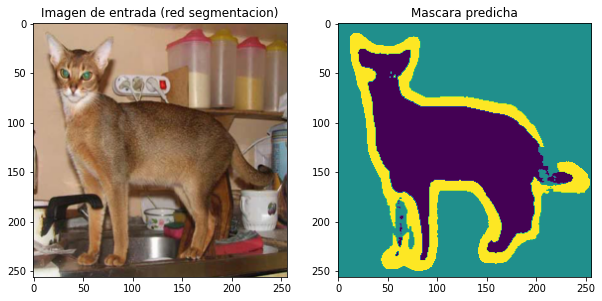

In [18]:
#@title ## Local images { display-mode: "form" }
img_path = "/content/Abyssinian_180.jpg"#@param {type:"string"}
images = [img_path]
all_images = False #@param {type:"boolean"}

if all_images:
    from glob import glob
    images = glob("/content/*.jpg")


for img_path in images:
    img = Image.open(img_path) 
    input = image_preprocess(img)

    #file_url = "" # clean input
    print("Image correctly downloaded.\nProcessing...\n")
    # plt.imshow(np.asarray(img)) # original image

    raw_mask = False #@param {type:"boolean"}
    show_predictions(input, raw_mask)



In [ ]:
#@title ## ¡¡ TEST IT !! { display-mode: "form" }


#@markdown ### Enter an image url:
file_url = "https://catpedia.net/wp-content/uploads/2018/01/Bengal-cat.jpg,https://www.mascotahogar.com/1920x1080/wallpaper-de-un-caballo-salvaje.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Volorful-parrot-animal-wallpaper-HD.jpg,https://www.pixelstalk.net/wp-content/uploads/images2/Screen-Download-Animal-Wallpapers.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-background.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpaper-HD-for-free.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-Birds-Wallpaper-HD-1920x1080.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-free-download.jpg,https://tailandfur.com/wp-content/uploads/2014/09/beautiful-and-cute-animals-wallpaper-51.jpg,https://4.bp.blogspot.com/-CO5-mntxeWo/Tvc3bTvFLTI/AAAAAAAAT18/H0Zu1zr_ITM/s1600/animals-widescreen-wallpapers-animals.jpg,https://3.bp.blogspot.com/-Gf-f7GSnp8U/Tvc3auZfg8I/AAAAAAAAT1s/zaWFB9tHT3c/s1600/Animals%2BWallpapers.jpg,https://1.bp.blogspot.com/_UmpGmlMW_Ek/TKJil9BMv_I/AAAAAAAAAAU/HgflMrUMvX8/w1200-h630-p-k-no-nu/bicicletas+specialized.jpg,https://astelus.com/wp-content/viajes/paisaje-marino-lago-jackson.jpg,http://dibujos.drawing-of.eu/wp-content/uploads/2017/03/kot.jpg,https://i2.wp.com/consciouscat.net/wp-content/uploads/2015/11/kitten-drawing.jpg,https://www.masscience.com/wp-content/uploads/2016/01/infinito.jpg,https://i.pinimg.com/originals/aa/96/94/aa9694a73702278c3b09aadfeecef7e4.jpg,https://i.ytimg.com/vi/H6Iq-pTxbAs/hqdefault.jpg" #@param {type:"string"}
#@markdown ---

# Simulate a User-Agent header value.
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}

def process_image(url):
    # Send request with simulated User-Agent header. 
    req = Request(url=url, headers=headers)

    try:
        with urlopen(req) as response:
            c = response.read()
        img = Image.open(BytesIO(c))
        input = image_preprocess(img)
        
        #file_url = "" # clean input
        print("Image correctly downloaded.\nProcessing...\n")
        # plt.imshow(np.asarray(img)) # original image

        raw_mask = False #@param {type:"boolean"}
        show_predictions(input, raw_mask)
    except Exception as e:
        print(e)
        #print("ERROR, please change the url.\n\n", e)




### MAIN PART
urls = file_url.split(",")
for i,url in enumerate(urls):
    print("\n -- Image {}/{}".format(i+1,len(urls)))
    print(url)
    process_image(url)


Output hidden; open in https://colab.research.google.com to view.